# BMI/CS 576 HW1
The objectives of this homework are to practice

* with the basic algorithms for sequence assembly
* reasoning about graphs and paths for the sequence assembly task

## HW policies
Before starting this homework, please read over the [homework policies](https://canvas.wisc.edu/courses/167969/pages/hw-policies) for this course.  In particular, note that homeworks are to be completed *individually*.

You are welcome to use any code from the weekly notebooks in your solutions to the HW.

## PROBLEM 1: The greedy algorithm for fragment assembly (60 points)
Write a function, `greedy_assemble`, that takes as input a list of read strings and uses the greedy fragment assembly algorithm to output a *single* superstring that contains all reads as substrings. You must use the graph-based (Hamiltonian path) version of the greedy algorithm. We will assume that:
1. we are assembling a single-stranded sequence and
2. that no read is a substring of any other read.

To keep things simple, for this homeowork, we will allow overlaps of any length (including zero).  In practice, for sequence assembly we would typically require some minimum overlap length.

### Tie-breaking criteria

For the purpose of making this algorithm deterministic, we must establish tiebreaking criteria for edges in the overlap graph that have the same weight. For two edges with the same weight, we will first choose the edge whose source vertex read is first in lexicographical order. If the source vertices are identical, then we choose the edge whose target vertex read is first in lexicographical order. For example, if e1 = ATCGGA → GGAT and e2 = ATCGGA → GGAA, we will attempt to use edge e2 first because GGAA < GGAT according to lexicographical order.

In [2]:
# Code for PROBLEM 1
# You are welcome to develop your code as a separate Python module
# and import it here if that is more convenient for you.
import itertools
import queue
from operator import itemgetter

class Graph:
    def __init__(self, vertices):
        self.out_edges = {v : [] for v in vertices}
        self.in_edges = {v : [] for v in vertices}
        self.num_edges = 0
    
    def add_edge(self, i, j):
        self.out_edges[i].append(j)
        self.in_edges[j].append(i)
        self.num_edges += 1
    
    def indegree(self, i):
        return len(self.in_edges[i])
        
    def outdegree(self, i):
        return len(self.out_edges[i])
    
    def is_connected(self, start, end):
        out_vertices = self.out_edges[start]
        while out_vertices:
            v = out_vertices[0]
            if v == end:
                return True
            out_vertices = self.out_edges[v]
        return False
    
    def get_path(self, start):
        path = [start]
        out_vertices = self.out_edges[start]
        while out_vertices:
            v = out_vertices[0]
            path.append(v)
            out_vertices = self.out_edges[v]
        return path

    
def overlap_length(left, right):    
    length = min(len(left), len(right))
    return next((i for i in range(length, 0, -1) if left.endswith(right[:i])), 0)

    
def merge_ordered_reads(reads):
    result = ""
    
    for read in reads:
        result += read[overlap_length(result, read):]
        
    return result 


def greedy_assemble(reads):
    """Assembles a set of reads using the graph-based greedy algorithm.
    
    Args:
        reads: a list of strings
    Returns:
        A string that is a superstring of the input reads
    """
    q = queue.PriorityQueue()
    for (u, v) in itertools.permutations(reads, 2):
        q.put((-overlap_length(u, v), u, v))
    
    g = Graph(reads)
    
    length = len(reads)
    while g.num_edges < length - 1:
        _, u, v = q.get()
        if g.outdegree(u) == 0 and g.indegree(v) == 0 and not g.is_connected(v, u):
            g.add_edge(u, v)
        
    
    start = next(e for e in reads if g.indegree(e) == 0)
    path = g.get_path(start)
    return merge_ordered_reads(path)

Tests for `greedy_assemble` are provided at the bottom of this notebook.

## PROBLEM 2: Assembling a small subset of Ebola virus reads (10 points)

Included with this notebook is the file `ebola_reads.txt` which is small subset of the Illumina reads used to assemble the genome of an isolate of the Ebola virus, which caused a major epidemic in West Africa. 

Use your greedy assemble function to assemble these reads. Once correctly assembled, these reads form a short segment of the genome of this virus. To allow your assembler to succeed, the reads have been cleaned of errors and have have been oriented so that they all come from the same strand of the genome.  You may find the following function below of use, which produces a list of reads from the contents of a file.

In [3]:
def read_strings_from_file(filename):
    return [line.rstrip() for line in open(filename)]

In [5]:
###
### code for assembling the ebola reads
###

greedy_assemble(read_strings_from_file("ebola_reads.txt"))

'ATTAAGAAAAACTGCTTATTGGGTCTTTCCGTGTTTTAGATGAAGCAGTTGACATTCTTCCTCTTGATATTAAATGGCTACACAACATACCCAATACCCAGACGCCAGGTTATCATCACCAATTGTATTGGACCAATGTGACCTTGTCACTAGAGCTTGCGGGTTGTATTCATCATACTCCCTTAATCCGCAACTACGCAACTGTAAACTCCCGAAACATATATACCGTTTAAAATATGATGTAACTGTTACCAAGTTCTTAAGTGATGTACCAGTGGCGACATTGCCCATAGATTTCATAGTCCCAATTCTTCTCAAGGCACTATCAGGCAATGGGTTCTGTCCTGTTGAGCCGCGGTGCCAACAGTTCTTAGATGAAATTATTAAGTACACAATGCAAGATGCTCTCTTCCTGAAATATTATCTCAAAAATGTGGGTGCTCAAGAAGACTGTGTTGATGACCACTTTCAAGAAAAAATCTTATCTTCAATTCAGGGCAATGAATTTTTACATCAAATGTTTTTCTGGTATGACCTGGCTATTTTAACTCGAAGGGGTAGATTAAATCGAGGAAACTCTAGATCAACGTGGTTTGTTCATGATGATTTAATAGACATCTTAGGCTATGGGGACTATGTTTTTTGGAAGATCCCAATTTCACTGTTACCACTGAACACACAAGGAATCCCCCATGCTGCTATGGATTGGTATCAGACATCAGTATTCAAAGAAGCGGTTCAAGGGCATACACACATTGTTTCTGTTTCTACTGCCGATGTCTTGATAATGTGCAAAGATTTAATTACATGTCGATTCAACACAACTCTAATCTCAAAAATAGCAGAGGTTGAGGACCCAGTTTGCTCTGATTATCCCAATTTTAAGATTGTGTCTATGCTTTACCAGAGCGGAGATTACTTACTCTCCATATTAGGGTCTGATGGGTATAAAATCATTAAGTTTCTCGAACCATTGTGCTTGGCTAAAATTCAATTGTG

Once you have assembled the genomic segment, use the [BLAST](https://blast.ncbi.nlm.nih.gov/Blast.cgi) web service to search the NCBI database of proteins with your assembled sequence. You should use BLASTX with its default settings. Based on the results of your BLASTX search, which gene is contained within this genomic segment?


** Zaire ebolavirus **


### BONUS CHALLENGE
A subset of Illumina reads from an Ebola virus genome sequencing experiment that cover the entire genome are included in the file `ebola_full_genome_reads.txt`. Can you get your code to assemble these reads in under 2 minutes? Sorry, no extra credit here, just personal satisfaction!

## PROBLEM 3: SBH graphs and Eulerian paths (20 points) 
For the following strings, (i) give the k = 3 spectrum for the string, (ii) draw the SBH graph for the spectrum, (iii) give one Eulerian path and its corresponding string for the SBH graph, and (iv) show whether or not there exists an Eulerian path in the graph that corresponds to the original string.

(a) ATGGCCTGAATCC

(b) ATAGCCTAGCAAT

In [4]:
from graphviz import Digraph

def get_spectrum(string, k):
    return {string[i:i+k] for i in range(len(string)-k+1)}
    
def draw_sbh(spectrum):
    g = Digraph(engine='neato')
    g.edges((e[:-1], e[1:]) for e in spectrum)
    return g

def answer_i_ii(string, k, ):
    spectrum = get_spectrum(string, k)
    print(f"(i). The spectrum for {string} is {spectrum}")
    print(f"(ii). The SBH graph for this spectrum is shown below: ")
    return draw_sbh(spectrum)

### Part (a): ATGGCCTGAATCC

(i). The spectrum for ATGGCCTGAATCC is {'GCC', 'TCC', 'TGG', 'CTG', 'GAA', 'ATG', 'AAT', 'TGA', 'GGC', 'ATC', 'CCT'}
(ii). The SBH graph for this spectrum is shown below: 


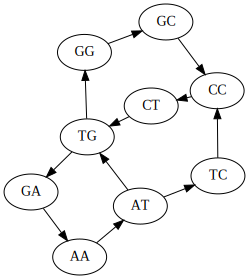

In [5]:
answer_i_ii("ATGGCCTGAATCC", 3)

(iii). A Eulerian path for this SBH graph is AT -> TG -> GG -> GC -> CC -> CT -> TG -> GA -> AA -> AT -> TC -> CC. Its corrseponding string is "ATGGCCTGAATCC"

(iv).  There exists an Eulerian path in the graph that corresponds to the original string.

### Part (b): ATAGCCTAGCAAT

(i). The spectrum for ATAGCCTAGCAAT is {'AGC', 'GCC', 'ATA', 'CAA', 'AAT', 'TAG', 'CTA', 'GCA', 'CCT'}
(ii). The SBH graph for this spectrum is shown below: 


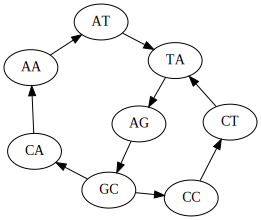

In [6]:
answer_i_ii("ATAGCCTAGCAAT", 3)

(iii). A Eulerian path for this SBH graph is GC -> CA -> AA -> AT -> TA -> AG -> GC -> CC -> CT -> TA. Its corrseponding string is "GCAATAGCCTA"

(iv).  There does not exist an Eulerian path in the graph that corresponds to the original string.

## PROBLEM 4: Existence of DNA sequence with complete spectrum (10 points)
For any value of $k$, does there exist a DNA sequence that contains every possible $k$-mer exactly once?  Prove your answer.  *Hint: consider the SBH graph for the spectrum of such a sequence, should it exist*

Construct a SBH graph with 
- $V$ = { all $(k-1)$-mer }
- $E$ = { $(u,v)$ | the last $(k-2)$ characters of $u$ is the same as the first $(k-2)$ characters of $v$ }

Then there are $4^k$ edges in total, each corrseponds to a unique $k$-mer by merging the source vertex and destination vertex with one copy of the overlay

For each edge in the graph, there are exactly 4 in-edges and 4 out-edges since the last/first character can only differ by 4 bases. Furthermore, the graph is strongly connected (i.e., there exists a path between every pair of vertices). 

Therefore the graph contains a Eulerian path, which corresponds to a sequence that contains every possible $k$-mer exactly once. 

### Tests for problem 1

In [7]:
def test_greedy_assemble_with_files(reads_filename, superstring_filename):
    reads = read_strings_from_file(reads_filename)
    [superstring] = read_strings_from_file(superstring_filename)
    assert greedy_assemble(reads) == superstring 

In [8]:
# TEST: greedy_assemble returns a string
sanity_test_reads = read_strings_from_file("tests/test_reads.txt")
assert isinstance(greedy_assemble(sanity_test_reads), str)
print("SUCCESS: greedy_assemble returns a string passed!")

SUCCESS: greedy_assemble returns a string passed!


In [9]:
# TEST: greedy_assemble returns a superstring
def is_superstring(s, reads):
    return all(read in s for read in reads)
assert is_superstring(greedy_assemble(sanity_test_reads), sanity_test_reads)
print("SUCCESS: greedy_assemble returns a superstring passed!")

SUCCESS: greedy_assemble returns a superstring passed!


In [10]:
# TEST: greedy_assemble_small_test_1
small_test1_reads = ["GTT", "ATCTC", "CTCAA"]
assert greedy_assemble(small_test1_reads) == "ATCTCAAGTT"
print("SUCCESS: greedy_assemble_small_test_1 passed!")

SUCCESS: greedy_assemble_small_test_1 passed!


In [11]:
# TEST: greedy_assemble_small_test_2
small_test2_reads = ["CGAAG", "ATCGA", "AGAG", "GGG"]
assert greedy_assemble(small_test2_reads) == "ATCGAAGAGGG"
print("SUCCESS: greedy_assemble_small_test_2 passed!")

SUCCESS: greedy_assemble_small_test_2 passed!


In [12]:
# TEST: greedy_assemble_small_test_3
small_test3_reads = ["C", "T", "G", "A"]
assert greedy_assemble(small_test3_reads) == 'ACGT'
print("SUCCESS: greedy_assemble_small_test_3 passed!")

SUCCESS: greedy_assemble_small_test_3 passed!


In [13]:
# TEST: greedy_assemble large test 1
test_greedy_assemble_with_files("tests/large_test1_reads.txt", "tests/large_test1_superstring.txt")
print("SUCCESS: greedy_assemble large test 1 passed!")

SUCCESS: greedy_assemble large test 1 passed!


In [14]:
# TEST: greedy_assemble_reads_7 (hidden)
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [15]:
# TEST: greedy_assemble_reads_8 (hidden)
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [16]:
# TEST: greedy_assemble_reads_9 (hidden)
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [17]:
# TEST: greedy_assemble_reads_10 (hidden)
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [18]:
# TEST: greedy_assemble_reads_11 (hidden)
###
### AUTOGRADER TEST - DO NOT REMOVE
###
